In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#Import CSV
#colnames, as they are not specified in DS
pd.options.display.max_columns = 50
colnames = ["id", "age", "gender", "education", "country", "ethnicity", 
            "neuroticism", "extraversion", "openness", "agreeableness",
           "conscientiousness", "impulsiveness", "sensation_seeking",
           "alcohol", "amphet", "amyl", "benzos", "caff", "cannabis",
           "choc", "coke", "crack", "ecstasy", "heroin", "ketamine",
           "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]
drugs = pd.read_csv('data/drug_consumption.csv', header = None, names = colnames, index_col = False)

# preprocessing (reverse transformation)
#relabelling from web source
age = {-0.07854: "25-34", -0.95197: "18-24", 2.59171: "65+", 1.82213: "55-64", 1.09449: "45-54", 0.49788: "35-45"}
gender = {0.48246: "Female", -0.48246: "Male"}
education = {-1.43719: "Left school at 17 years", -1.73790: "Left school at 16 years", -2.43591: "Left school before 16 years",
           0.45468: "University degree", -0.05921: "Professional certificate/ diploma", -0.61113: "Some college or university, no certificate or degree",
           -1.22751: "Left school at 18 years", 1.98437: "Doctorate degree", 1.16365: "Masters degree"}
country = {0.21128: "Republic of Ireland", -0.28519: "Other", -0.46841: "New Zealand", 0.24923: "Canada",
          -0.09765: "Australia", -0.57009: "USA", 0.96082: "UK"}
ethnicity = {-0.31685: "White", 0.11440: "Other", -0.22166: "Mixed-White/Black", 0.12600: "Mixed-White/Asian",
           1.90725: "Mixed-Black/Asian", -1.10702: "Black", -0.50212: "Asian"}

# rounding error must be corrected: website only contains 5 decimal numbers
drugs.age = round(drugs.age,5)
drugs.age = drugs.age.replace(age.keys(), age.values())
drugs.gender = round(drugs.gender, 5)
drugs.gender = drugs.gender.replace(gender.keys(), gender.values())
drugs.education = round(drugs.education, 5)
drugs.education = drugs.education.replace(education.keys(), education.values())
drugs.country = round(drugs.country, 5)
drugs.country = drugs.country.replace(country.keys(), country.values())
drugs.ethnicity = round(drugs.ethnicity, 5)
drugs.ethnicity = drugs.ethnicity.replace(ethnicity.keys(), ethnicity.values())

drugs.head()

#list of dicts for reverse transformation of the other variables
#these variables have more possible values, so it would be very time
#intense to do that manually as well
label_list = []
#extract informatioin from txt file created from web source
with open("data/drug_data-description.txt", "r") as file:
    data = file.readlines()
    for line in data:
        ### if line start with digit -> new variable section begins
        if line[0].isdigit():
            ### create new dict in list for each variable
            label_list.append(dict())
        ### only lines starting with <br> contain information
        if line[0:4] == "<br>":
            ### get clean numbers out of line
            numbers = line.split()[1:]
            #transform them from str to numeric
            for i in range(len(numbers)):
                if numbers[i].isdigit():
                    numbers[i] = int(numbers[i])
                else:
                    numbers[i] = float(numbers[i])
            ### append needed values to last (current) dict in list
            if len(numbers) == 6:
                numbers.pop(1)
                numbers.pop(3)
            if len(numbers) == 9:
                numbers.pop(1)
                numbers.pop(3)
                numbers.pop(5)
            for i in range(1, len(numbers), 2):
                label_list[len(label_list)-1][numbers[i]] = numbers[i-1]

## retransform variables according to dict
for i in range(len(label_list)):
    drugs.iloc[:,i+6] = round(drugs.iloc[:, i+6], 5)
    drugs.iloc[:,i+6] = drugs.iloc[:,i+6].replace(label_list[i].keys(), label_list[i].values())

#change data types
for i in range(1, 6):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
for i in range(6, 11):
    drugs[colnames[i]] = drugs[colnames[i]].astype("int32")
    
#########takes some time
#### removing "CL*"    
for i in range(13, len(colnames)):
    for j in range(0, len(drugs[colnames[i]])):
        drugs.iloc[j,i] = int(drugs.iloc[j,i][-1])
drugs.head()

for i in range(13, len(colnames)):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
print(drugs.info())
print(drugs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
id                   1885 non-null int64
age                  1885 non-null category
gender               1885 non-null category
education            1885 non-null category
country              1885 non-null category
ethnicity            1885 non-null category
neuroticism          1885 non-null int32
extraversion         1885 non-null int32
openness             1885 non-null int32
agreeableness        1885 non-null int32
conscientiousness    1885 non-null int32
impulsiveness        1885 non-null float64
sensation_seeking    1885 non-null float64
alcohol              1885 non-null category
amphet               1885 non-null category
amyl                 1885 non-null category
benzos               1885 non-null category
caff                 1885 non-null category
cannabis             1885 non-null category
choc                 1885 non-null category
coke                 1885 non-nul

### Data Set Description

The Data Set contains information about the frequency of drug use depending on different demographic and psychological attributes. It contains 1885 observations on 32 variables, wehereas one is the ID and 19 can be considered as target variables as they contain information on the frequencey of drug use on different kind of drugs. We decided to only work on one specific drug (cannabis). Therefore the data set consists of 12 features. The features are numerical and categorical. The target variable has seven different values (never used the drug - used it yesterday), therefore it can be considered as a multiple class problem.
The target variable is inequally distributed as most people eather never consumed cannabis or used it wihtin the last day (both > 20%). Inbetween the values vary about 10%. Most people are and come form UK or USA and are mostly young (< 25 years). Almost all participants have a degree, indicating that the study was conducted at university. The psychological attributes are approximately normally distributed. There are only very few values which are extreme outliers beside that there are no peculiarities. The data set does not contain missing values.


## 3 Statistical Analysis

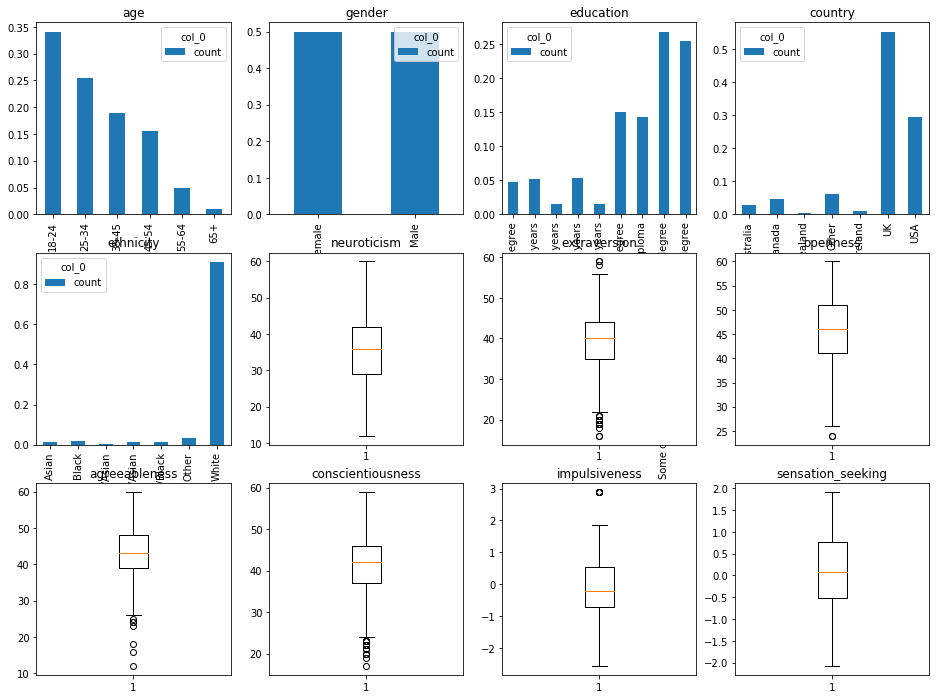

In [2]:
fig, axlist = plt.subplots(3,4,figsize=(16,12))
variable = 1
for row in range(0,3):
    for i in range(0,4):
        if drugs[colnames[variable]].dtype == "int32" or drugs[colnames[variable]].dtype == "float64":
            axlist[row][i].boxplot(drugs[colnames[variable]])
            axlist[row][i].set_title(colnames[variable])
        else:
            tab = pd.crosstab(drugs[colnames[variable]], columns="count")
            rel_tab = tab/tab.sum()
            rel_tab.plot(kind = "bar", ax = axlist[row][i])
            axlist[row][i].set_title(colnames[variable])
        variable += 1

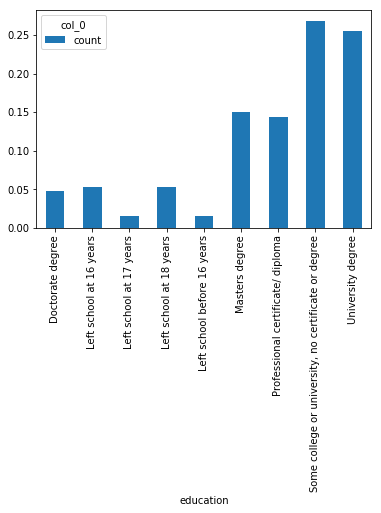

In [3]:
tab = pd.crosstab(drugs["education"], columns = "count")
rel_tab = tab/tab.sum()
rel_tab.plot(kind = "bar")

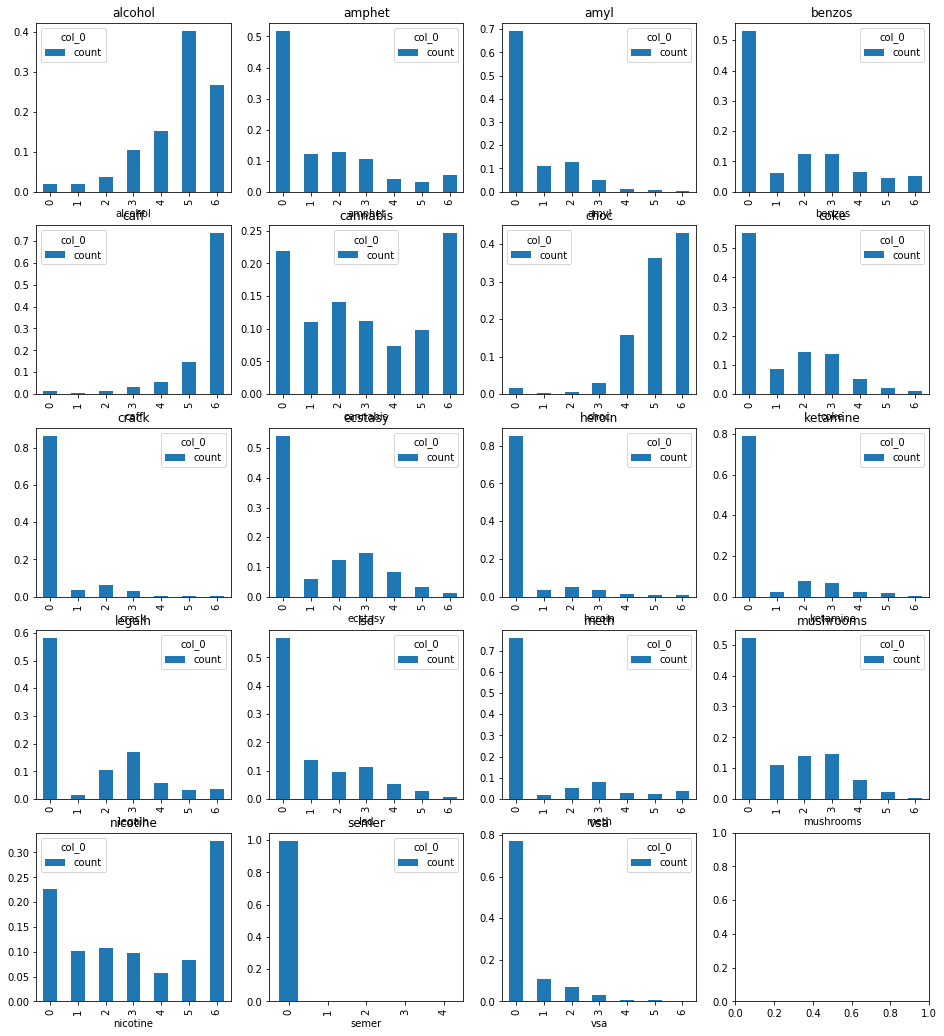

In [4]:
fig, axlist = plt.subplots(5,4,figsize=(16,18))
for row in range(0,5):
    for i in range(0,4):
        tab = pd.crosstab(drugs[colnames[variable]], columns="count")
        rel_tab = tab/tab.sum()
        rel_tab.plot(kind = "bar", ax = axlist[row][i])
        axlist[row][i].set_title(colnames[variable])
        if variable == 31:
            break
        variable += 1

In [5]:
drugs.isna().sum() # The number of missing values per Attribute (column)

id                   0
age                  0
gender               0
education            0
country              0
ethnicity            0
neuroticism          0
extraversion         0
openness             0
agreeableness        0
conscientiousness    0
impulsiveness        0
sensation_seeking    0
alcohol              0
amphet               0
amyl                 0
benzos               0
caff                 0
cannabis             0
choc                 0
coke                 0
crack                0
ecstasy              0
heroin               0
ketamine             0
legalh               0
lsd                  0
meth                 0
mushrooms            0
nicotine             0
semer                0
vsa                  0
dtype: int64

In [6]:
drugs.shape # Check dimensions

(1885, 32)

In [7]:
drugs.iloc[:,1:].describe() #without id

,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,35.921485,39.576127,45.762334,42.866313,41.437135,0.007216,-0.003292
std,9.135869,6.771769,6.579641,6.438106,6.966625,0.954435,0.963701
min,12.000000,16.000000,24.000000,12.000000,17.000000,-2.555240,-2.078480
25%,29.000000,35.000000,41.000000,39.000000,37.000000,-0.711260,-0.525930
50%,36.000000,40.000000,46.000000,43.000000,42.000000,-0.217120,0.079870
75%,42.000000,44.000000,51.000000,48.000000,46.000000,0.529750,0.765400
max,60.000000,59.000000,60.000000,60.000000,59.000000,2.901610,1.921730


There is no statistical summary for categorical data. We can get a summary of the categorical variables by passing only those columns to describe():

In [8]:
categorical = drugs.dtypes[drugs.dtypes == "category"].index #gives list of attributes that are categorical
drugs[categorical].describe()

,age,gender,education,country,ethnicity,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,6,2,9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,18-24,Male,"Some college or university, no certificate or ...",UK,White,5,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,6,0,0
freq,643,943,506,1044,1720,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


In [9]:
#list of proportional frequency tables
prop_tables = []
for variable in categorical:
    tab = pd.crosstab(drugs[variable], columns="count")
    rel_tab = tab/tab.sum()
    prop_tables.append(rel_tab)

print(categorical)

for i in [0, 2, 5, 14]:
    print(prop_tables[i])
    print()
    

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semer', 'vsa'],
      dtype='object')
col_0     count
age            
18-24  0.341114
25-34  0.255172
35-45  0.188859
45-54  0.155968
55-64  0.049337
65+    0.009549

col_0                                                  count
education                                                   
Doctorate degree                                    0.047215
Left school at 16 years                             0.052520
Left school at 17 years                             0.015915
Left school at 18 years                             0.053050
Left school before 16 years                         0.014854
Masters degree                                      0.150133
Professional certificate/ diploma                   0.143236
Some college or university, no cer

## Testing Algorithms

In [3]:
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import minmax_scale
### to use recall precision in cross_validate
from sklearn.metrics.scorer import make_scorer


### extract means and stdevs of recall and precision
def get_mean(accumulator):
    rval = []
    for j in range(len(accumulator[0])):
        current = []
        for i in accumulator:
            current.append(i[j])
        rval.append(statistics.mean(current))
    return rval

def get_std(accumulator):
    rval = []
    for j in range(len(accumulator[0])):
        current = []
        for i in accumulator:
            current.append(i[j])
        rval.append(statistics.stdev(current))
    return rval

from sklearn.metrics import recall_score, precision_score

/home/niklas/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### The proper implementation of the experiments
This is what will be included in our report

In [4]:
### filter relevant features and target variable
Xdata = drugs.iloc[:,1:13]
Ydata = drugs.cannabis

### kNN

In [5]:
### Function to experiment with kNN
def knn_test(Xdata, Ydata, weights = "uniform", algorithm = "brute"):
    accuracy_mean = []
    accuracy_std = []
    fit_time = []
    score_time = []
    number_of_classes = len(Ydata.unique())

    ### list for each target class
    precision_mean = [ [] for i in range(number_of_classes) ]
    precision_std = [ [] for i in range(number_of_classes) ]
    recall_mean = [ [] for i in range(number_of_classes) ]
    recall_std = [ [] for i in range(number_of_classes) ]  
    recall_accumulator = []
    precision_accumulator = []
    ### always specify a list to save results before every call
    def my_precision(y_true, y_pred, **kwargs):
        precisions = precision_score(y_true, y_pred, **kwargs)
        nonlocal precision_accumulator
        precision_accumulator.append(precisions)
        return precisions.mean()

    ### always specify a list to save results before every call
    def my_recall(y_true, y_pred, **kwargs):
        recalls = recall_score(y_true, y_pred, **kwargs)
        nonlocal recall_accumulator
        recall_accumulator.append(recalls)
        return recalls.mean()
    scoring = {"accuracy":"accuracy", "precision":make_scorer(my_precision, average=None), "recall":make_scorer(my_recall, average=None)}

    for i in range(2,101):
        knn = KNeighborsClassifier(i, weights=weights, algorithm = algorithm)
        recall_accumulator = []
        precision_accumulator = []
        scores = cross_validate(knn, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
        accuracy_mean.append(scores["test_accuracy"].mean())
        accuracy_std.append(scores["test_accuracy"].std())
        fit_time.append(scores["fit_time"].mean())
        score_time.append(scores["score_time"].mean())
        
        prec_means = get_mean(precision_accumulator)
        prec_stds = get_std(precision_accumulator)
        rec_means = get_mean(recall_accumulator)
        rec_stds = get_std(recall_accumulator)
        

             
        for i in range(number_of_classes):
            precision_mean[i].append(prec_means[i])
            precision_std.append(prec_stds[i])
            recall_mean[i].append(rec_means[i])
            recall_std[i].append(rec_stds[i])

        
    #Plot
    plt.figure(figsize=(16, 10))
    plt.subplot(2,2,1)
    plt.plot(accuracy_mean)
    plt.plot(accuracy_std)
    plt.title("Accuracy")
    plt.xlabel("k")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,2)
    for i in range(number_of_classes):
        plt.plot(precision_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Precision")
    plt.xlabel("k")
    plt.subplot(2,2,3)
    for i in range(number_of_classes):
        plt.plot(recall_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Recall")
    plt.xlabel("k")
    plt.legend(sorted(Ydata.unique()))
    plt.subplot(2,2,4)
    plt.plot(fit_time)
    plt.plot(score_time)
    plt.title("Time")
    plt.xlabel("k")
    plt.legend(("Fit Time", "Score Time"))
    
    return {"accuracy":accuracy_mean, "std":accuracy_std}

In [6]:
import warnings
warnings.filterwarnings("ignore")
Xdata_dummy = pd.get_dummies(Xdata)
Xdata_dummy.head()

,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking,age_18-24,age_25-34,age_35-45,age_45-54,age_55-64,age_65+,gender_Female,gender_Male,education_Doctorate degree,education_Left school at 16 years,education_Left school at 17 years,education_Left school at 18 years,education_Left school before 16 years,education_Masters degree,education_Professional certificate/ diploma,"education_Some college or university, no certificate or degree",education_University degree,country_Australia,country_Canada,country_New Zealand,country_Other,country_Republic of Ireland,country_UK,country_USA,ethnicity_Asian,ethnicity_Black,ethnicity_Mixed-Black/Asian,ethnicity_Mixed-White/Asian,ethnicity_Mixed-White/Black,ethnicity_Other,ethnicity_White
0,39,36,42,37,42,-0.21712,-1.18084,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,29,52,55,48,41,-0.71126,-0.21575,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,31,45,40,32,34,-1.37983,0.40148,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,34,34,46,47,46,-1.37983,-1.18084,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,43,28,43,41,50,-0.21712,-0.21575,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [7]:
Xdata_source = pd.DataFrame.copy(Xdata)

for i in range(5):
    lable_encoder = LabelEncoder()
    Xdata_source.iloc[:,i] = lable_encoder.fit_transform(Xdata_source.iloc[:,i])
    
print(Xdata_source.head())

   age  gender  education  country  ethnicity  neuroticism  extraversion  \
0    2       0          6        5          3           39            36   
1    1       1          0        5          6           29            52   
2    2       1          6        5          6           31            45   
3    0       0          5        5          6           34            34   
4    2       0          0        5          6           43            28   

   openness  agreeableness  conscientiousness  impulsiveness  \
0        42             37                 42       -0.21712   
1        55             48                 41       -0.71126   
2        40             32                 34       -1.37983   
3        46             47                 46       -1.37983   
4        43             41                 50       -0.21712   

   sensation_seeking  
0           -1.18084  
1           -0.21575  
2            0.40148  
3           -1.18084  
4           -0.21575  


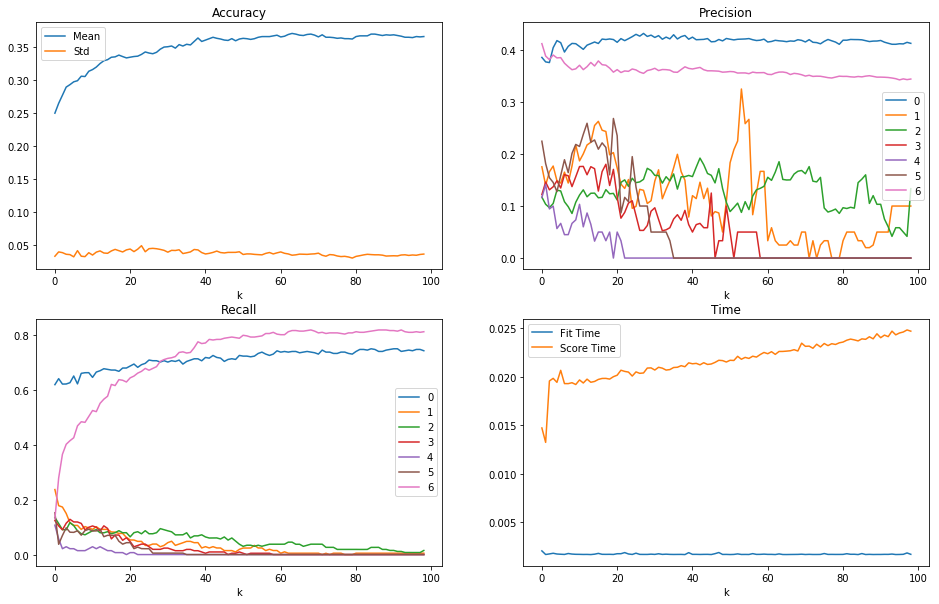

In [141]:
### Experiment 1: k-range 2:100, algorithm = brute, weights = uniform, source
results = knn_test(Xdata_source, Ydata, weights="uniform", algorithm="brute")

In [149]:
results["std"][0]

0.03336342078166644

[0.2532240305040078,
 0.2685114153919882,
 0.27541296056271447,
 0.29196957093867315,
 0.29460387579168634,
 0.2929904913972516,
 0.29997603821135116,
 0.3019900089745306,
 0.30313526165322785,
 0.30742167245261404,
 0.31317306942140816,
 0.31589421383666116,
 0.3212053119530673,
 0.32166981606218514,
 0.3296776736563194,
 0.33603588748763014,
 0.3408577387015102,
 0.33708849554182785,
 0.3418904613346618,
 0.33652315817846823,
 0.3333794547535928,
 0.3344037577982974,
 0.3375872541639503,
 0.3366017361197733,
 0.3435062936514838,
 0.344511518842329,
 0.34398259566667555,
 0.34191905226449265,
 0.3429630883375635,
 0.3498677969055785,
 0.3519678438257549,
 0.35514022382702537,
 0.3551572351186889,
 0.35567267252355567,
 0.3540708814436745,
 0.3534967745381649,
 0.35457462113630656,
 0.3545637187713315,
 0.35879397246127176,
 0.3593594885844956,
 0.35984103127339223,
 0.3630103612975397,
 0.3614114447824856,
 0.3609046555481751,
 0.36036438689129596,
 0.35774350193384263,
 0.35615039242

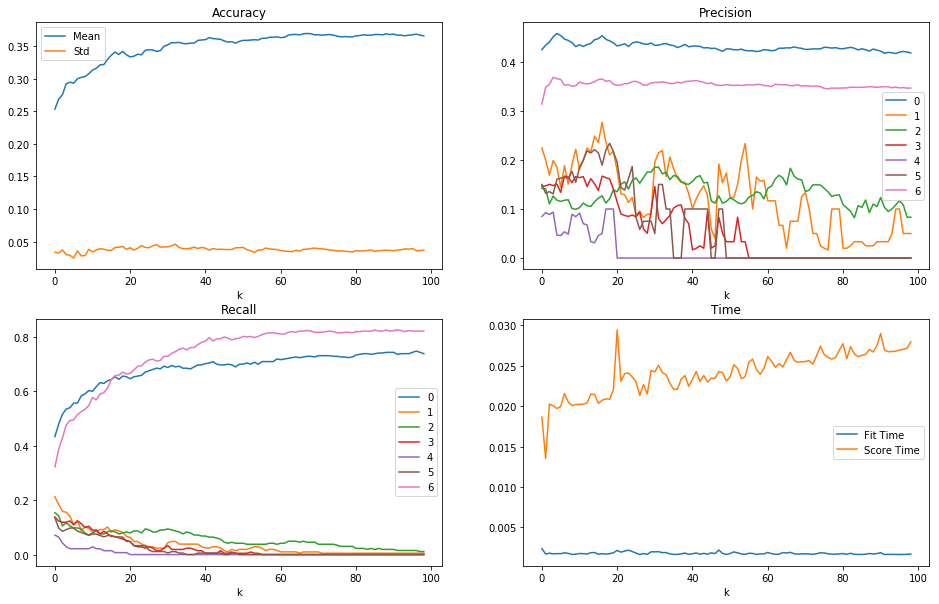

In [18]:
### Experiment 2: k-range 2:100, algorithm = brute, weights = distance, source
knn_test(Xdata_source, Ydata, weights="distance", algorithm="brute")

{'accuracy': [0.2803448062619958,
  0.3170113524356147,
  0.3202369283639672,
  0.33141094468278,
  0.35002380894368507,
  0.35164491489644906,
  0.3537112688801357,
  0.35850535596797506,
  0.3542804243298046,
  0.3584435674167456,
  0.3596392529359182,
  0.36075342618409256,
  0.36440951514480824,
  0.37087185165314485,
  0.3804131766568623,
  0.3761261464079987,
  0.3856319437926663,
  0.38612471621606925,
  0.3840441930287952,
  0.3830055190010229,
  0.38886299048253953,
  0.3835575846430453,
  0.38401388224219274,
  0.3877653460010252,
  0.38666483485686415,
  0.3850943046801205,
  0.38455690923169317,
  0.38515670996807694,
  0.3893923285653977,
  0.3904396540612526,
  0.3888748132993388,
  0.393127083876775,
  0.39203803720883784,
  0.3909096392106671,
  0.3903469398285554,
  0.3898571308648223,
  0.386642942203044,
  0.39250304928921287,
  0.38771575596728,
  0.3872313034239711,
  0.38721136153558533,
  0.38718890163112823,
  0.38664572690284965,
  0.38768451851920294,
  0.3871

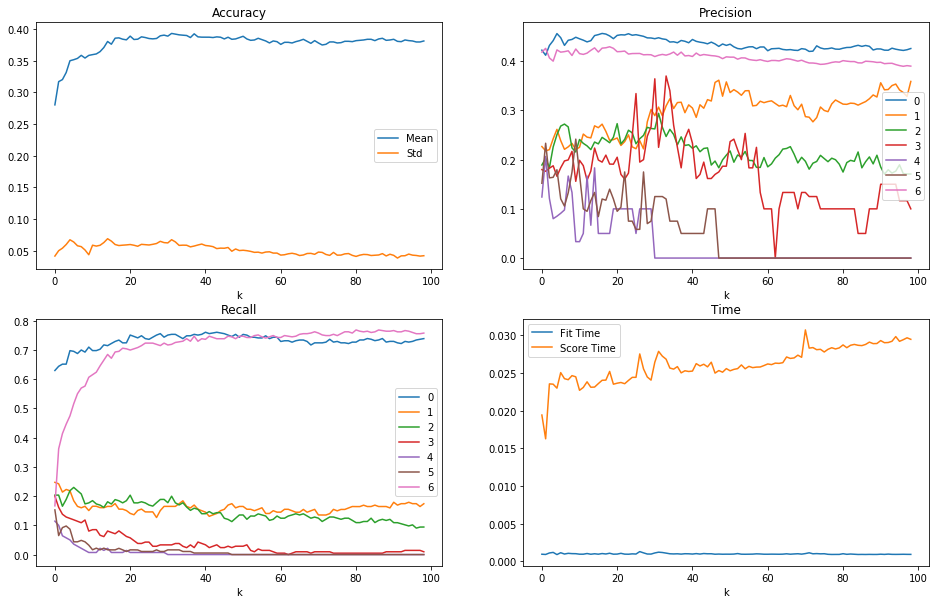

In [8]:
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_source)

### Experiment 3: k-range 2:100, algorithm = brute, weights = uniform, scale
knn_test(X_minmax, Ydata, weights="uniform", algorithm="brute")

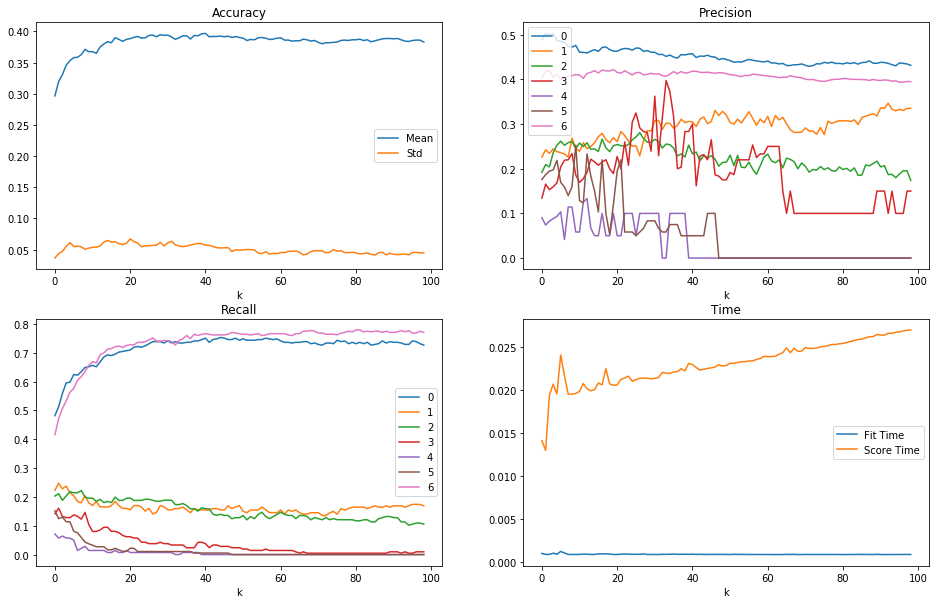

In [150]:
### Experiment 4: k-range 2:100, algorithm = brute, weights = distance, scale
results = knn_test(X_minmax, Ydata, weights="distance", algorithm="brute")

In [153]:
results["std"][98]

0.04459227976111246

In [9]:
### scale [0, 1]
min_max_scaler = MinMaxScaler()
Xdata_dummy_minmax = min_max_scaler.fit_transform(Xdata_dummy)

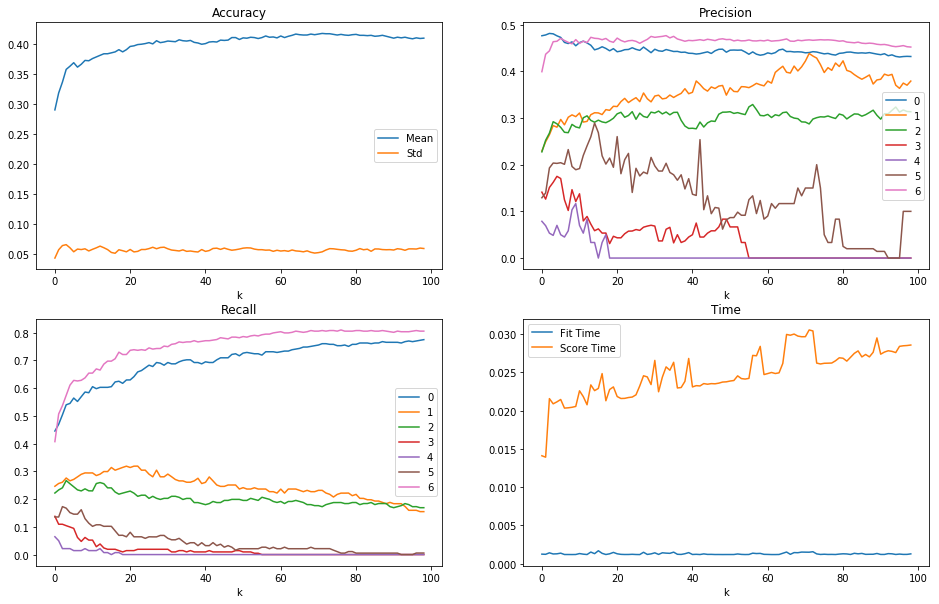

In [154]:
results = knn_test(Xdata_dummy_minmax, Ydata, weights="distance", algorithm="brute")

In [161]:
results["std"][0]

0.042506096762304546

[0.23621812505553805,
 0.2702248254234358,
 0.28552341038121165,
 0.28140183287543624,
 0.2968862916921632,
 0.29677297996112867,
 0.312098972060745,
 0.3217083225944955,
 0.31377098552684946,
 0.32278030572188654,
 0.3217612810170676,
 0.32179047405167616,
 0.32441650656953414,
 0.32497639158712943,
 0.3265534205877514,
 0.3302373832115768,
 0.32810388231508536,
 0.3312849716081534,
 0.3371164265932081,
 0.3355154073554842,
 0.34080128810570093,
 0.3370860259415844,
 0.33443429915740774,
 0.34342794434153545,
 0.3471404513712676,
 0.3444724013328822,
 0.3413568815959481,
 0.3476902364516868,
 0.34818822560824764,
 0.34451806152742304,
 0.3450269831491142,
 0.34503270358503013,
 0.34876793444016135,
 0.3519171391121152,
 0.3535218061632405,
 0.3582761266274448,
 0.35355840517112974,
 0.35300989520018144,
 0.35621258608734385,
 0.3556945972186823,
 0.35514049002527337,
 0.3535080597690382,
 0.35403973856456245,
 0.3556160771010921,
 0.35401147165669455,
 0.3540227324122869,
 0.352410095

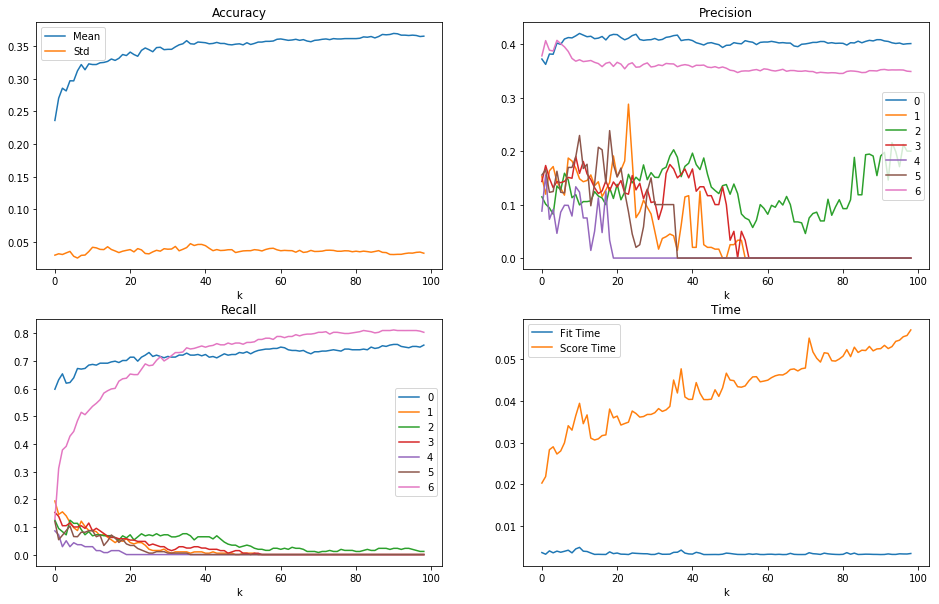

In [18]:
### Experiment 5: k-range 2:100, algorithm = kd_tree, weights = uniform, source
knn_test(Xdata_dummy, Ydata, weights="uniform", algorithm="kd_tree")

[0.27662008409163696,
 0.3250408365846107,
 0.33889476386102774,
 0.3516175431935253,
 0.35748365057562903,
 0.36227453994756725,
 0.3664231896095844,
 0.36543222111075224,
 0.3733977295963705,
 0.36873669013001403,
 0.3771858813572246,
 0.3851882292173241,
 0.38036952633254467,
 0.3856834966371822,
 0.3856982467531774,
 0.3866721507905327,
 0.38826511499003524,
 0.3983445169838716,
 0.3962532391203588,
 0.39777265578582444,
 0.4020932858086301,
 0.4030556323065032,
 0.4015243320883995,
 0.401566610667787,
 0.39672263065195207,
 0.39521687332770744,
 0.3989574394255084,
 0.4053157708454001,
 0.39845376041867325,
 0.40217180684715104,
 0.40324414279032694,
 0.4021378242073107,
 0.3994892395926264,
 0.4010879209305185,
 0.3994274011198624,
 0.39885880486931846,
 0.4020870983159165,
 0.40316245462154654,
 0.4010851032684756,
 0.40210425264241473,
 0.4073816305342158,
 0.40474732795850865,
 0.40421224123068855,
 0.4031111925006015,
 0.4036545732268177,
 0.39993679348207434,
 0.397296328374

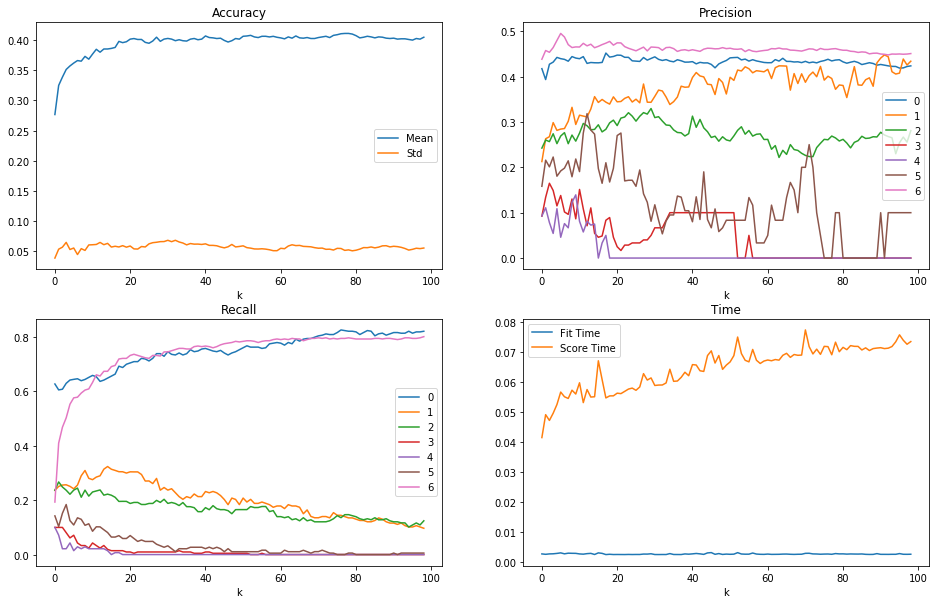

In [19]:
### Experiment 6: k-range 2:100, algorithm = kd_tree, weights = uniform, scale
knn_test(X_minmax, Ydata, weights="uniform", algorithm="kd_tree")

[0.28945311528546686,
 0.3176299977898469,
 0.33566639417575267,
 0.35692618295943673,
 0.36223179479686857,
 0.3680700007422609,
 0.3607006065424714,
 0.36547382474429535,
 0.37189680429752403,
 0.3713202954588174,
 0.37502657558708324,
 0.37769495435137523,
 0.3803604618483666,
 0.382953223368231,
 0.38300092230211835,
 0.384509940305367,
 0.3860860117227179,
 0.3898156439489714,
 0.3861311662733496,
 0.389838069534816,
 0.3951945023180933,
 0.3961908347533332,
 0.39830462850315634,
 0.39890421853765906,
 0.39994855561307674,
 0.4015360669813287,
 0.39941634301463924,
 0.4046913792235959,
 0.40152166449168847,
 0.4025773785549044,
 0.4041818363105657,
 0.40361629430564383,
 0.40307578484672824,
 0.4062447258946168,
 0.4046878537027189,
 0.4041451545181943,
 0.4051976360614103,
 0.40199734375987645,
 0.40093632833715886,
 0.3988448190794969,
 0.3999003200642361,
 0.4025576469329552,
 0.4031176537575886,
 0.40255157368125427,
 0.40572952458784284,
 0.40522006959868284,
 0.4057520112949

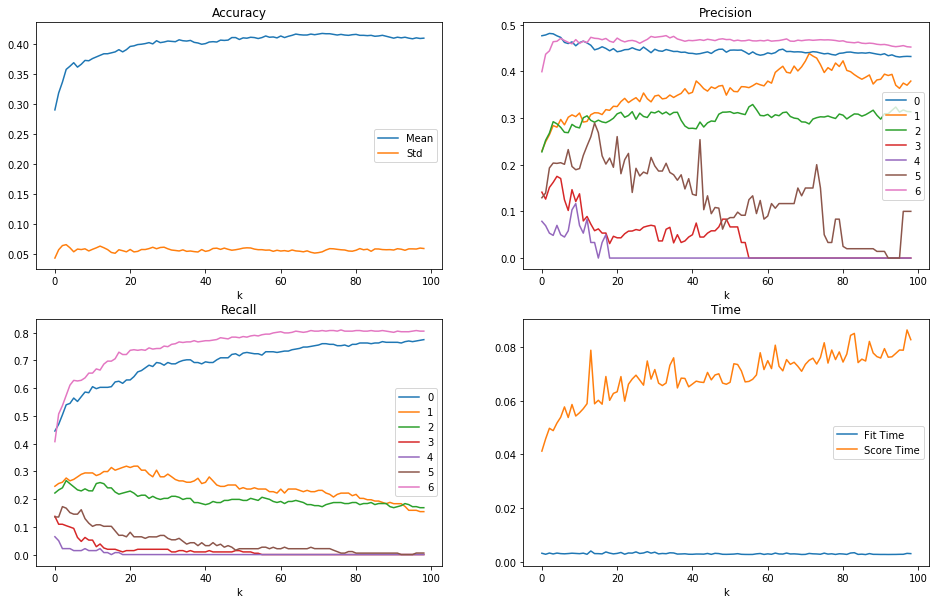

In [20]:
### Experiment 7: k-range 2:100, algorithm = kd_tree, weights = distance, scale
knn_test(X_minmax, Ydata, weights="distance", algorithm="kd_tree")

### Naive Bayes

In [10]:
def naive_test(classifier, Xdata, Ydata):
    precision_accumulator = []
    recall_accumulator = []
    def my_precision(y_true, y_pred, **kwargs):
        precisions = precision_score(y_true, y_pred, **kwargs)
        nonlocal precision_accumulator
        precision_accumulator.append(precisions)
        return precisions.mean()

    ### always specify a list to save results before every call
    def my_recall(y_true, y_pred, **kwargs):
        recalls = recall_score(y_true, y_pred, **kwargs)
        nonlocal recall_accumulator
        recall_accumulator.append(recalls)
        return recalls.mean()
    scoring = {"accuracy":"accuracy", "precision":make_scorer(my_precision, average=None), "recall":make_scorer(my_recall, average=None)}
    
    scores = cross_validate(classifier, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
       
    prec_means = get_mean(precision_accumulator)
    prec_stds = get_std(precision_accumulator)
    rec_means = get_mean(recall_accumulator)
    rec_stds = get_std(recall_accumulator)
    
    rval = {"fit_time":scores["fit_time"].mean(), "score_time":scores["score_time"].mean(), 
            "accuracy":scores["test_accuracy"].mean(), "accuracy_std":scores["test_accuracy"].std(),
            "precision_means":prec_means, "precision_std":prec_stds, "recall_means":rec_means, "recall_std":rec_stds}
    
    for i in rval:
        print(i + ":\n", rval[i])
    
    return rval

In [131]:
results = naive_test(GaussianNB(), Xdata_source, Ydata)

fit_time:
 0.003268146514892578
score_time:
 0.0040920495986938475
accuracy:
 0.3668838186795669
accuracy_std:
 0.05792157612873884
precision_means:
 [0.5142809823007091, 0.2981337435406908, 0.286182099634112, 0.18474594246333376, 0.05666666666666667, 0.16666666666666666, 0.39901812506202206]
precision_std:
 [0.07146723543154529, 0.11658465479638164, 0.1323570781027198, 0.09201738318379013, 0.0916919157145678, 0.32394177193585005, 0.03694649363716286]
recall_means:
 [0.5666666666666667, 0.3757142857142857, 0.1282051282051282, 0.12337662337662338, 0.02142857142857143, 0.01637426900584795, 0.6769657724329324]
recall_std:
 [0.11923767284426703, 0.1296874938339904, 0.06566798780615543, 0.051474917696210584, 0.03450327796711771, 0.026377085497132174, 0.13752667006791516]


In [11]:
Xdata_source_positive = pd.DataFrame.copy(Xdata_source)
Xdata_source_positive["impulsiveness"] = minmax_scale(Xdata_source["impulsiveness"])
Xdata_source_positive["sensation_seeking"] = minmax_scale(Xdata_source["sensation_seeking"])
Xdata_source_positive.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
0,2,0,6,5,3,39,36,42,37,42,0.428474,0.224398
1,1,1,0,5,6,29,52,55,48,41,0.337920,0.465658
2,2,1,6,5,6,31,45,40,32,34,0.215401,0.619957
3,0,0,5,5,6,34,34,46,47,46,0.215401,0.224398
4,2,0,0,5,6,43,28,43,41,50,0.428474,0.465658


In [132]:
results = naive_test(MultinomialNB(), Xdata_source_positive, Ydata)

fit_time:
 0.002821946144104004
score_time:
 0.0039167642593383786
accuracy:
 0.3626710688343834
accuracy_std:
 0.043773078652217155
precision_means:
 [0.4277384797504798, 0.23935064935064934, 0.15757212086159456, 0.15364468864468864, 0.0, 0.0, 0.39186638499664933]
precision_std:
 [0.06988004972354925, 0.1434168056846747, 0.044316612317249635, 0.07186583136165975, 0.0, 0.0, 0.03803584157637962]
recall_means:
 [0.69732868757259, 0.09619047619047619, 0.07492877492877492, 0.08982683982683982, 0.0, 0.0, 0.727104532839963]
recall_std:
 [0.12167492621563013, 0.058989133008132494, 0.0346023225928266, 0.05171957532164459, 0.0, 0.0, 0.16428715941881558]


In [133]:
results = naive_test(BernoulliNB(), Xdata_source_positive, Ydata)

fit_time:
 0.0033746957778930664
score_time:
 0.003699851036071777
accuracy:
 0.3434608300469932
accuracy_std:
 0.035731719639881754
precision_means:
 [0.3688085678060145, 0.08333333333333333, 0.175, 0.0, 0.0, 0.2, 0.3370131618012571]
precision_std:
 [0.052320745647978034, 0.13608276348795434, 0.33437337746231466, 0.0, 0.0, 0.42163702135578396, 0.031127515803374427]
recall_means:
 [0.6418118466898954, 0.014285714285714285, 0.011396011396011397, 0.0, 0.0, 0.010818713450292398, 0.808418131359852]
recall_std:
 [0.10247760011726377, 0.023002185311411807, 0.018353416989636932, 0.0, 0.0, 0.022818260836405462, 0.09248170074081519]


In [83]:
Xdata_source.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
0,2,0,6,5,3,39,36,42,37,42,-0.21712,-1.18084
1,1,1,0,5,6,29,52,55,48,41,-0.71126,-0.21575
2,2,1,6,5,6,31,45,40,32,34,-1.37983,0.40148
3,0,0,5,5,6,34,34,46,47,46,-1.37983,-1.18084
4,2,0,0,5,6,43,28,43,41,50,-0.21712,-0.21575


In [12]:
#discretize continuis variables
Xdata_disc = pd.DataFrame.copy(Xdata_source)

for i in range(5,12):
    quantiles = Xdata_source.iloc[:,i].quantile([0,0.2,0.4,0.6,0.8,1])
    Xdata_disc.iloc[:,i] = pd.cut(Xdata_source.iloc[:,i], quantiles, include_lowest=True)

Xdata_lable = Xdata_disc    
    
for i in range(5,12):
    lable_encoder = LabelEncoder()
    Xdata_lable.iloc[:,i] = lable_encoder.fit_transform(Xdata_lable.iloc[:,i])


In [85]:
Xdata_lable.head()
for i in range(12):
    Xdata_lable.iloc[:,i] = Xdata_lable.iloc[:,i].astype("category")

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
0,2,0,6,5,3,3,1,1,0,2,1,0
1,1,1,0,5,6,1,4,4,3,2,0,1
2,2,1,6,5,6,1,3,0,0,0,0,2
3,0,0,5,5,6,2,0,2,3,3,0,0
4,2,0,0,5,6,3,0,1,1,4,1,1


In [134]:
results = naive_test(MultinomialNB(), Xdata_lable, Ydata)

fit_time:
 0.006562185287475586
score_time:
 0.005805277824401855
accuracy:
 0.37636537620277927
accuracy_std:
 0.0375915877579246
precision_means:
 [0.43791059175458846, 0.3416666666666667, 0.17829365079365078, 0.1738095238095238, 0.0, 0.0, 0.3805889410376499]
precision_std:
 [0.05016707534104501, 0.2642541332005618, 0.1230838479203492, 0.31427970172218894, 0.0, 0.0, 0.02806524946821996]
recall_means:
 [0.7263646922183508, 0.09666666666666666, 0.08262108262108261, 0.028138528138528136, 0.0, 0.0, 0.7807585568917669]
recall_std:
 [0.13801218876322824, 0.045525403438922356, 0.05472343761970154, 0.03937305526592281, 0.0, 0.0, 0.1272528120375808]


In [135]:
results = naive_test(GaussianNB(), Xdata_lable, Ydata)

fit_time:
 0.006865692138671875
score_time:
 0.0070626258850097655
accuracy:
 0.36310428838592973
accuracy_std:
 0.05158832990628404
precision_means:
 [0.5118785800883178, 0.28653416246063307, 0.2287984237984238, 0.20624902874902876, 0.05333333333333333, 0.1, 0.39564132778143407]
precision_std:
 [0.08773762357784785, 0.10041192322716175, 0.13062197952973403, 0.10043644569987642, 0.11674600476945507, 0.31622776601683794, 0.03701879652783038]
recall_means:
 [0.5619628339140534, 0.36142857142857143, 0.10541310541310542, 0.14155844155844155, 0.014285714285714285, 0.005263157894736842, 0.6834875115633673]
recall_std:
 [0.12485588537601365, 0.13107882303531915, 0.06220141650071345, 0.07174634518894288, 0.03011693009684171, 0.01664356663246515, 0.13395028227656441]


In [136]:
results = naive_test(BernoulliNB(), Xdata_lable, Ydata)

fit_time:
 0.006496167182922364
score_time:
 0.00618448257446289
accuracy:
 0.3640533880239434
accuracy_std:
 0.036677820012240465
precision_means:
 [0.4161194531906876, 0.16666666666666666, 0.18211171869066606, 0.21833333333333332, 0.05, 0.0, 0.38438633002127887]
precision_std:
 [0.06274423862157481, 0.32394177193585005, 0.06840371106433436, 0.14602764832070012, 0.15811388300841897, 0.0, 0.0389500408198753]
recall_means:
 [0.7018002322880371, 0.014285714285714285, 0.1198005698005698, 0.03787878787878788, 0.007142857142857143, 0.0, 0.7611933395004625]
recall_std:
 [0.11408526679081686, 0.023002185311411807, 0.059433754886685175, 0.01997527878774477, 0.02258769757263128, 0.0, 0.13729431575924614]


In [115]:
X_complete_dummy.head()

,age_0,age_1,age_2,age_3,age_4,age_5,gender_0,gender_1,education_0,education_1,education_2,education_3,education_4,education_5,education_6,education_7,education_8,country_0,country_1,country_2,country_3,country_4,country_5,country_6,ethnicity_0,...,extraversion_4,openness_0,openness_1,openness_2,openness_3,openness_4,agreeableness_0,agreeableness_1,agreeableness_2,agreeableness_3,agreeableness_4,conscientiousness_0,conscientiousness_1,conscientiousness_2,conscientiousness_3,conscientiousness_4,impulsiveness_0,impulsiveness_1,impulsiveness_2,impulsiveness_3,impulsiveness_4,sensation_seeking_0,sensation_seeking_1,sensation_seeking_2,sensation_seeking_3
0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [137]:
results = naive_test(GaussianNB(), X_complete_dummy, Ydata)

fit_time:
 0.003785991668701172
score_time:
 0.004774737358093262
accuracy:
 0.1909322598066662
accuracy_std:
 0.018119890171061494
precision_means:
 [0.7043772893772894, 0.2552939797725028, 0.08666666666666667, 0.10719685079534857, 0.06666666666666667, 0.18117292231049692, 0.1]
precision_std:
 [0.21015907722726032, 0.1049960965905806, 0.21326387758240137, 0.06262056068184271, 0.1097134314340639, 0.030968089228354697, 0.31622776601683794]
recall_means:
 [0.11091753774680604, 0.6273809523809524, 0.011253561253561254, 0.23766233766233766, 0.02857142857142857, 0.6798245614035088, 0.002173913043478261]
recall_std:
 [0.06433977959761432, 0.1633928270255656, 0.025165743872448833, 0.26108717628611916, 0.04994327848429293, 0.17737854226254604, 0.006874516652539954]


In [139]:
results = naive_test(MultinomialNB(), X_complete_dummy, Ydata)

fit_time:
 0.0030457735061645507
score_time:
 0.0028954267501831053
accuracy:
 0.39141428060400657
accuracy_std:
 0.0664265905169766
precision_means:
 [0.4913311401396648, 0.4040073651838358, 0.23774471024471025, 0.17067948391477802, 0.18333333333333332, 0.19833333333333333, 0.4386485214163893]
precision_std:
 [0.07892568249831709, 0.21351821361106105, 0.11243311939867895, 0.1509585515651483, 0.3374742788552764, 0.22117112530044844, 0.055696388918685155]
recall_means:
 [0.7092915214866434, 0.2319047619047619, 0.18005698005698006, 0.08528138528138528, 0.02142857142857143, 0.04269005847953216, 0.6904717853839037]
recall_std:
 [0.15526760761575256, 0.0922835356107598, 0.06228907468032854, 0.07372169955089569, 0.03450327796711771, 0.054497290463958056, 0.19240934115677436]


In [140]:
results = naive_test(BernoulliNB(), X_complete_dummy, Ydata)

fit_time:
 0.004168987274169922
score_time:
 0.00365142822265625
accuracy:
 0.3818952683014963
accuracy_std:
 0.05782223097787732
precision_means:
 [0.5220519330980689, 0.3746015734292397, 0.2491905216905217, 0.17231137283768863, 0.10138888888888889, 0.21396284271284272, 0.44196808334971155]
precision_std:
 [0.06516145675145604, 0.1523757259661451, 0.09779133058339924, 0.10993315883804625, 0.16329537855810927, 0.11614752526988319, 0.07739903693555704]
recall_means:
 [0.6801974448315912, 0.2947619047619047, 0.19914529914529913, 0.1093073593073593, 0.03571428571428571, 0.08596491228070174, 0.6062442183163738]
recall_std:
 [0.13081608616758758, 0.11170363553612704, 0.034664819313091844, 0.0598563016830736, 0.050507627227610534, 0.0619380182712998, 0.1895283890523383]


### Random Forest

In [13]:
def test_rfc(Xdata, Ydata, criterion = "gini", min_samples_split = 2, min_samples_leaf = 1):
    accuracy_mean = []
    accuracy_std = []
    fit_time = []
    score_time = []
    number_of_classes = len(Ydata.unique())

    ### list for each target class
    precision_mean = [ [] for i in range(number_of_classes) ]
    precision_std = [ [] for i in range(number_of_classes) ]
    recall_mean = [ [] for i in range(number_of_classes) ]
    recall_std = [ [] for i in range(number_of_classes) ]  
    recall_accumulator = []
    precision_accumulator = []
    ### always specify a list to save results before every call
    def my_precision(y_true, y_pred, **kwargs):
        precisions = precision_score(y_true, y_pred, **kwargs)
        nonlocal precision_accumulator
        precision_accumulator.append(precisions)
        return precisions.mean()

    ### always specify a list to save results before every call
    def my_recall(y_true, y_pred, **kwargs):
        recalls = recall_score(y_true, y_pred, **kwargs)
        nonlocal recall_accumulator
        recall_accumulator.append(recalls)
        return recalls.mean()
    scoring = {"accuracy":"accuracy", "precision":make_scorer(my_precision, average=None), "recall":make_scorer(my_recall, average=None)}
 
    xaxis = []
    
    for i in range(0, 201, 10):
        xaxis.append(i)
    
    for i in range(0, 201, 10):
        if i == 0 :
            i += 1
        rfc = RandomForestClassifier(n_estimators=i, criterion=criterion, min_samples_split=min_samples_split, random_state=0)
        scores = cross_validate(rfc, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
    
        accuracy_mean.append(scores["test_accuracy"].mean())
        accuracy_std.append(scores["test_accuracy"].std())
        fit_time.append(scores["fit_time"].mean())
        score_time.append(scores["score_time"].mean())
        
        prec_means = get_mean(precision_accumulator)
        prec_stds = get_std(precision_accumulator)
        rec_means = get_mean(recall_accumulator)
        rec_stds = get_std(recall_accumulator)
        

             
        for i in range(number_of_classes):
            precision_mean[i].append(prec_means[i])
            precision_std.append(prec_stds[i])
            recall_mean[i].append(rec_means[i])
            recall_std[i].append(rec_stds[i])

    
    #Plot
    plt.figure(figsize=(16, 10))
    plt.subplot(2,2,1)
    plt.plot(xaxis, accuracy_mean)
    plt.plot(xaxis, accuracy_std)
    plt.title("Accuracy")
    plt.xlabel("k")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,2)
    for i in range(number_of_classes):
        plt.plot(xaxis, precision_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Precision")
    plt.xlabel("k")
    plt.subplot(2,2,3)
    for i in range(number_of_classes):
        plt.plot(xaxis, recall_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Recall")
    plt.xlabel("k")
    plt.legend(sorted(Ydata.unique()))
    plt.subplot(2,2,4)
    plt.plot(xaxis, fit_time)
    plt.plot(xaxis, score_time)
    plt.title("Time")
    plt.xlabel("k")
    plt.legend(("Fit Time", "Score Time"))
    
    return {"accuracy":accuracy_mean, "std":accuracy_std}

In [14]:
Xdata_source.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
0,2,0,6,5,3,39,36,42,37,42,-0.21712,-1.18084
1,1,1,0,5,6,29,52,55,48,41,-0.71126,-0.21575
2,2,1,6,5,6,31,45,40,32,34,-1.37983,0.40148
3,0,0,5,5,6,34,34,46,47,46,-1.37983,-1.18084
4,2,0,0,5,6,43,28,43,41,50,-0.21712,-0.21575


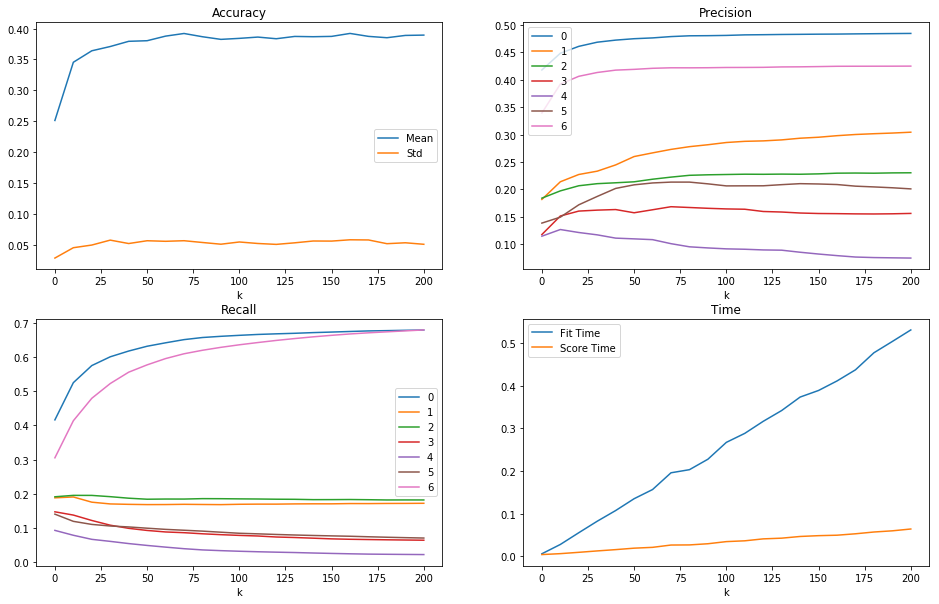

In [202]:
results = test_rfc(Xdata_source, Ydata, "gini", 2)

In [225]:
results["std"][0]

0.028117518319152796

In [162]:
results = test_rfc(Xdata_source, Ydata, "gini", 5)

KeyboardInterrupt: 

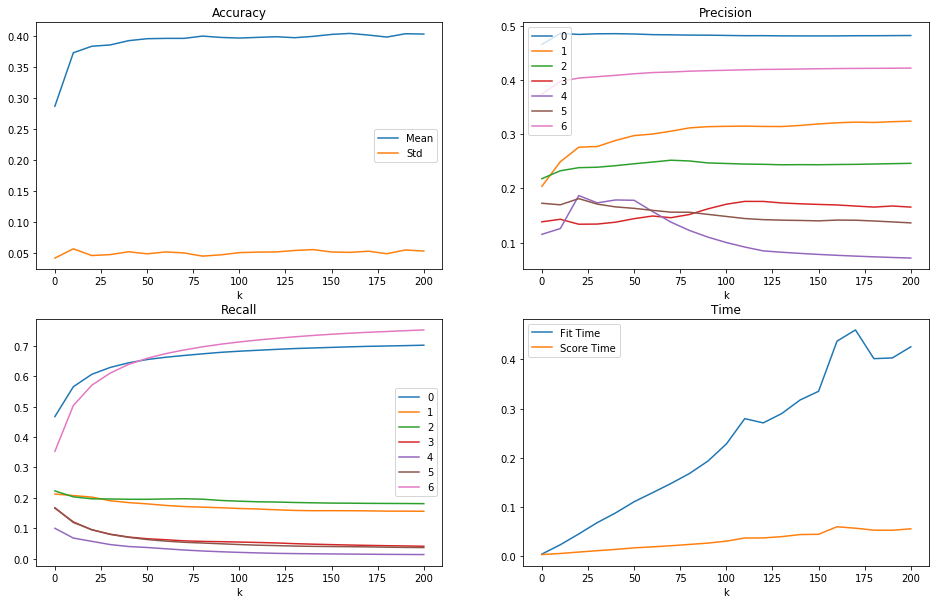

In [226]:
results = test_rfc(Xdata_source, Ydata, "gini", 10)

In [230]:
[results["std"][i] for i in [0,1,2,5,10,20]]

[0.04160262299003688,
 0.05649105669300576,
 0.04566088285817649,
 0.048412196408692806,
 0.05035102974574414,
 0.05296752738267359]

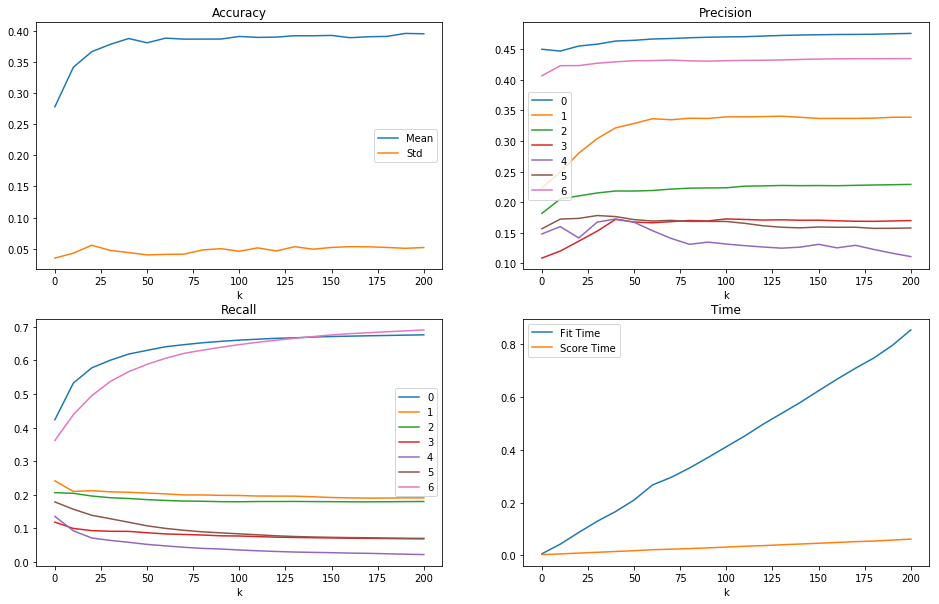

In [234]:
results = test_rfc(Xdata_source, Ydata, "entropy", 2)

In [236]:
[results["std"][i] for i in [0,1,2,5,10,20]]

[0.03500387754317759,
 0.042834605940716655,
 0.0555798088466738,
 0.04003616705073359,
 0.04586812589471087,
 0.0519148936635028]

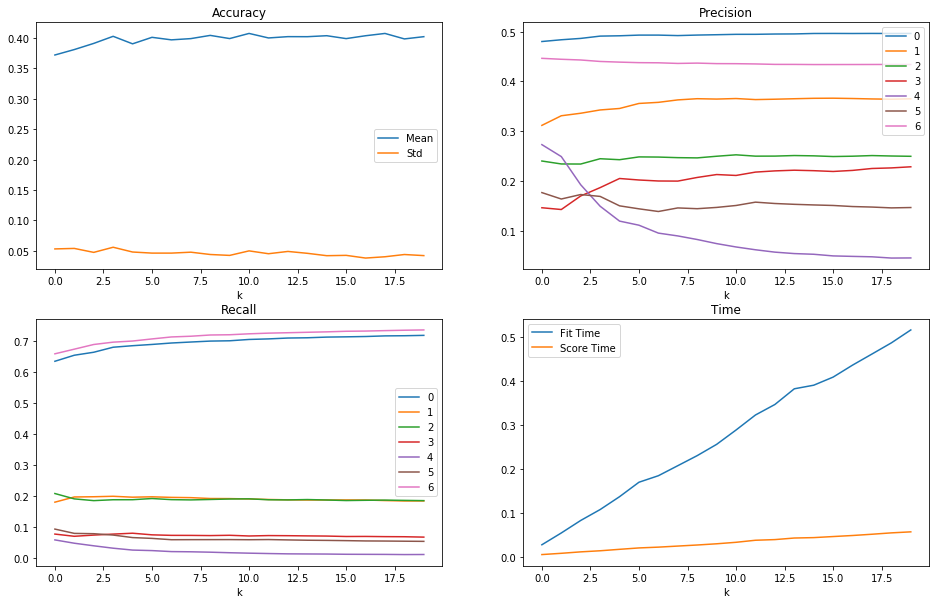

In [79]:
test_rfc(Xdata_lable, Ydata, "entropy", 5)

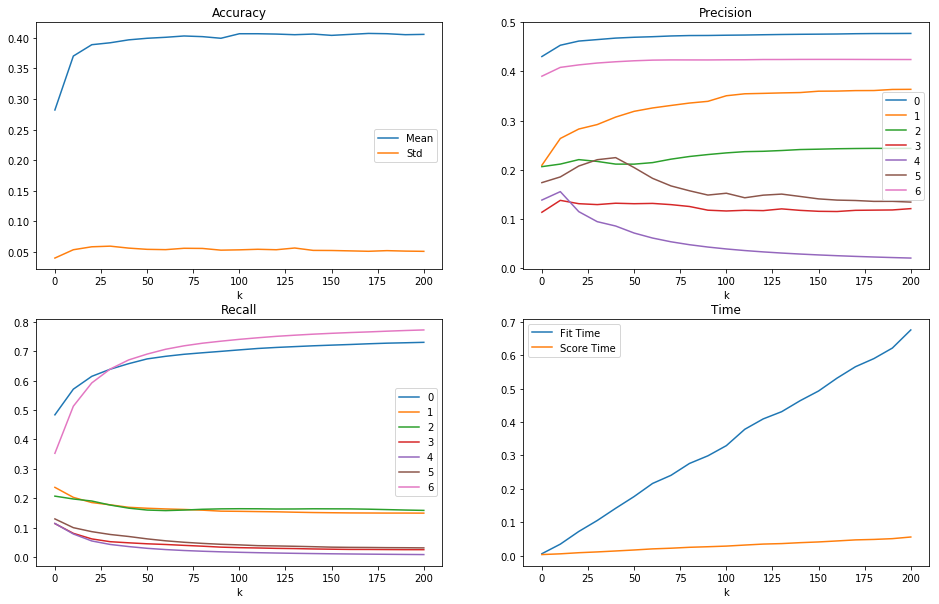

In [15]:
results = test_rfc(Xdata_source, Ydata, "entropy", 10)

In [18]:
[results["std"][i] for i in [0,1,2,5,10,20]]

[0.03961736182534666,
 0.053240740820203684,
 0.0580629671316041,
 0.053886841320293664,
 0.053068053284351886,
 0.050620599270063626]

In [17]:
Xdata_lable.head()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
0,2,0,6,5,3,3,1,1,0,2,1,0
1,1,1,0,5,6,1,4,4,3,2,0,1
2,2,1,6,5,6,1,3,0,0,0,0,2
3,0,0,5,5,6,2,0,2,3,3,0,0
4,2,0,0,5,6,3,0,1,1,4,1,1


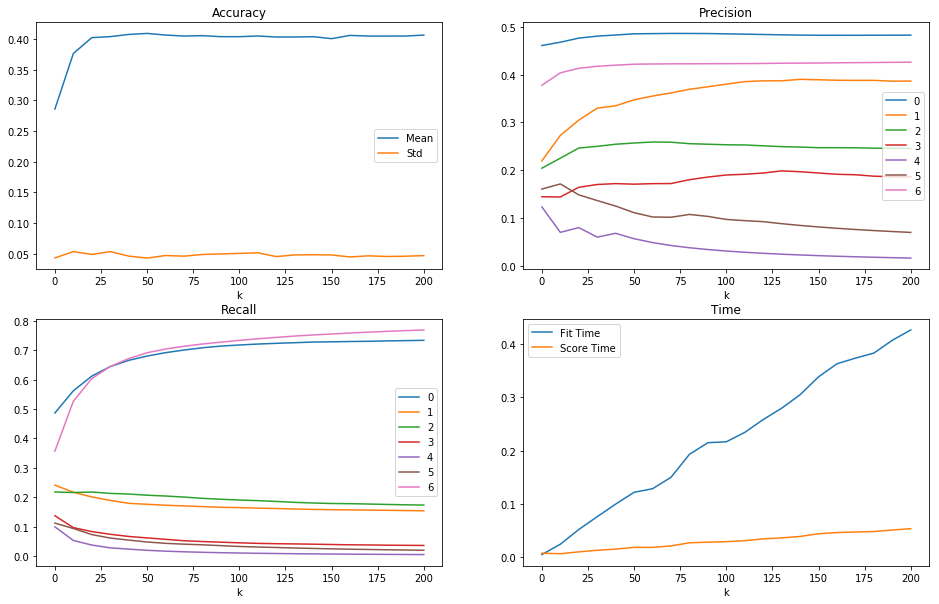

In [19]:
results = test_rfc(Xdata_lable, Ydata, "entropy", 10)

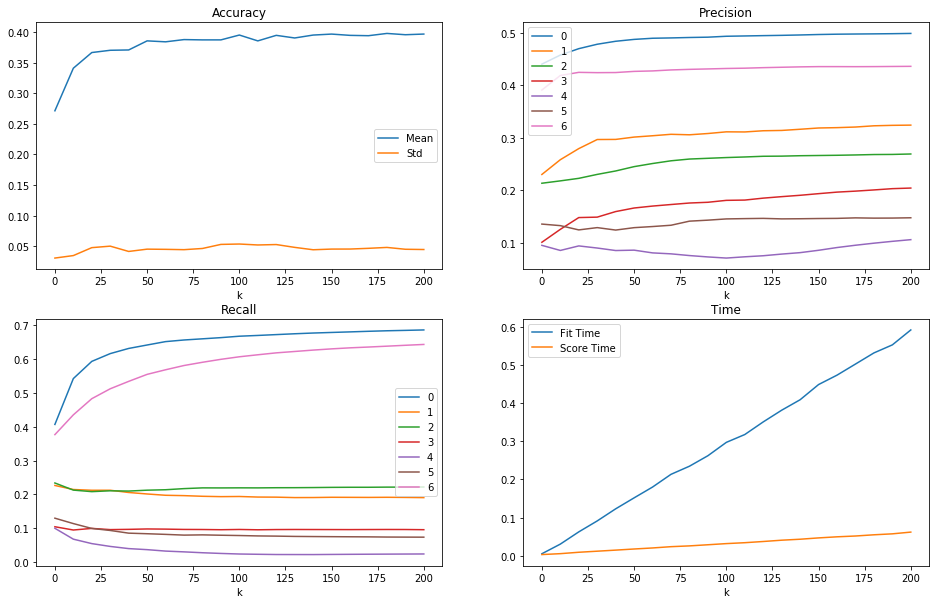

In [20]:
results = test_rfc(Xdata_lable, Ydata, "entropy", 2)